*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [1]:
# import libraries
#try:
  # %tensorflow_version only exists in Colab.
  #!pip install tf-nightly
#except Exception:
#  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import shutil

print(tf.__version__)

2.3.0


In [2]:
# get data files
TRAIN_DATA_URL = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/train-data.tsv"
TEST_DATA_URL = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/valid-data.tsv"

train_file_path = tf.keras.utils.get_file("train-data.tsv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("valid-data.tsv", TEST_DATA_URL)

In [3]:
train_data = pd.read_table(train_file_path, header=None)
test_data = pd.read_table(test_file_path, header=None)

In [4]:
train_data.columns= ['label','message']
test_data.columns= ['label','message']

In [5]:
train_data.groupby('label').describe().T

label                              ham                                               spam
message count                     3619                                                560
        unique                    3430                                                505
        top     sorry, i'll call later  hmv bonus special 500 pounds of genuine hmv vo...
        freq                        22                                                  3

In [6]:
test_data.groupby('label').describe().T

label                              ham                                               spam
message count                     1205                                                187
        unique                    1173                                                176
        top     sorry, i'll call later  u can win £100 of music gift vouchers every we...
        freq                         8                                                  2

In [7]:
ham_messages = train_data.loc[train_data['label']=='ham']
spam_messages = train_data.loc[train_data['label']=='spam']

In [8]:
ham_messages_sampled = ham_messages.sample(n=560)

In [9]:
train_data_downsampled = pd.concat([ham_messages_sampled,spam_messages])

In [10]:
train_data_downsampled = train_data_downsampled.sample(frac=1).reset_index(drop=True)

In [11]:
train_data_downsampled.groupby('label').describe().T

label                              ham                                               spam
message count                      560                                                560
        unique                     549                                                505
        top     sorry, i'll call later  hmv bonus special 500 pounds of genuine hmv vo...
        freq                         5                                                  3

In [12]:
test_data.groupby('label').describe().T

label                              ham                                               spam
message count                     1205                                                187
        unique                    1173                                                176
        top     sorry, i'll call later  u can win £100 of music gift vouchers every we...
        freq                         8                                                  2

In [13]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_token = "<OOV>" 
vocab_size = 600

In [14]:
words_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_token)
words_tokenizer.fit_on_texts(train_data_downsampled['message'])

In [15]:
# Get the word_index 
word_index = words_tokenizer.word_index


In [16]:
training_sequences = words_tokenizer.texts_to_sequences(train_data_downsampled['message'])
training_padded = tf.keras.preprocessing.sequence.pad_sequences(training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = words_tokenizer.texts_to_sequences(test_data['message'])
testing_padded = tf.keras.preprocessing.sequence.pad_sequences(testing_sequences, maxlen = max_len,padding = padding_type, truncating = trunc_type)

In [17]:
train_labels = train_data_downsampled['label'].map({'ham': 0., 'spam': 1.}).values
test_labels = test_data['label'].map({'ham': 0., 'spam': 1.}).values

In [18]:
embeding_dim = 16
drop_value = 0.5 # dropout
n_dense = 16

In [19]:
#Dense model architecture
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(n_dense, activation='relu'))
model.add(tf.keras.layers.Dropout(drop_value))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            9600      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 9,889
Trainable params: 9,889
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])


In [22]:
num_epochs = 40
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/40
35/35 - 0s - loss: 0.6884 - accuracy: 0.6357 - val_loss: 0.6841 - val_accuracy: 0.8297
Epoch 2/40
35/35 - 0s - loss: 0.6757 - accuracy: 0.7437 - val_loss: 0.6707 - val_accuracy: 0.8254
Epoch 3/40
35/35 - 0s - loss: 0.6434 - accuracy: 0.8107 - val_loss: 0.6462 - val_accuracy: 0.8010
Epoch 4/40
35/35 - 0s - loss: 0.5926 - accuracy: 0.8509 - val_loss: 0.6047 - val_accuracy: 0.8175
Epoch 5/40
35/35 - 0s - loss: 0.5190 - accuracy: 0.8750 - val_loss: 0.5449 - val_accuracy: 0.8333
Epoch 6/40
35/35 - 0s - loss: 0.4384 - accuracy: 0.8902 - val_loss: 0.4745 - val_accuracy: 0.8542
Epoch 7/40
35/35 - 0s - loss: 0.3609 - accuracy: 0.9143 - val_loss: 0.3860 - val_accuracy: 0.8865
Epoch 8/40
35/35 - 0s - loss: 0.3244 - accuracy: 0.9116 - val_loss: 0.3403 - val_accuracy: 0.9016
Epoch 9/40
35/35 - 0s - loss: 0.2701 - accuracy: 0.9295 - val_loss: 0.2848 - val_accuracy: 0.9224
Epoch 10/40
35/35 - 0s - loss: 0.2350 - accuracy: 0.9384 - val_loss: 0.2497 - val_accuracy: 0.9310
Epoch 11/40
35/35 -

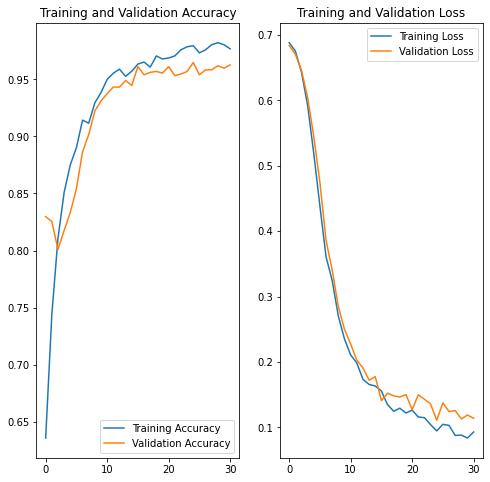

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = early_stop.stopped_epoch
epochs += 1 
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('Training_and_Validation_Accuracy.png')
plt.show()

In [24]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  labels = ['ham','spam']
  pred_text = [pred_text]
  tokenized_seq = words_tokenizer.texts_to_sequences(pred_text)
  padded_seq = tf.keras.preprocessing.sequence.pad_sequences(tokenized_seq, maxlen = max_len, padding = padding_type, truncating = trunc_type )
  prediction = model.predict(padded_seq).tolist()[0]
  label = round(prediction[0])
  label = labels[label]
  prediction.append(label)
  return prediction
pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[0.02306237816810608, 'ham']


In [25]:
test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
passed = True

for msg, ans in zip(test_messages, test_answers):
  prediction = predict_message(msg)
  print(prediction)

[0.02306237816810608, 'ham']
[0.6001617908477783, 'spam']
[0.019050180912017822, 'ham']
[0.9974952936172485, 'spam']
[0.9953740835189819, 'spam']
[0.016434848308563232, 'ham']
[0.040718674659729004, 'ham']


In [26]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!


In [27]:
model.save('model')
shutil.make_archive("model", 'zip', "model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/assets


'/content/model.zip'